In [4]:
import xarray as xr
import numpy as np

import datetime
import cartopy.crs as ccrs

import copy

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from WD.plotting import plot_map, add_label_to_axes

from benchmark.bm.score import compute_weighted_rmse, compute_weighted_mae, compute_weighted_acc

# Heat wave analysis:

Citing from "ANALYSES OF THE NORTHERN EUROPEAN SUMMER HEATWAVE OF 2018":

- maximum temperature anomaly of the 2018 heat wave was reached between July 15th and August 2nd
- the region that was most affected: $[5-30]°E, [55-70]°N$

In [5]:
# usually this would go on top of the notebook:
plt.rcParams.update({'font.size': 8})  # sets font size for all cells
plt.rcParams['figure.dpi'] = 300  # sets dpi for all cells

alphabet_letters = np.array(list(map(chr, range(65, 91))))  # used for labelling subplots
textwidth = 170  # 144  # in mm
mm_to_inch = 0.0393701
textwidth = textwidth * mm_to_inch # textwidth in inches

# First batch of experiments:

In [26]:
res = 5.625
lead_time = 3 # in days

# predictions = xr.load_dataset("/data/compoundx/WeatherDiff/model_output/{}/{}/{}/{}/gen.nc".format("rasp_thuerey_highres_z_500_3day", "unet_highres", "2023-09-14_16-53-47","2023-09-16_15-46-38"))
# targets = xr.load_dataset("/data/compoundx/WeatherDiff/model_output/{}/{}/{}/{}/target.nc".format("rasp_thuerey_highres_z_500_3day", "unet_highres", "2023-09-14_16-53-47","2023-09-16_15-46-38"))

predictions = xr.load_dataset("/data/compoundx/WeatherDiff/model_output/{}/{}/{}/{}/gen.nc".format("rasp_thuerey_z_500_3day", "unet", "2023-09-09_18-26-54","2023-09-13_20-55-01"))
targets = xr.load_dataset("/data/compoundx/WeatherDiff/model_output/{}/{}/{}/{}/target.nc".format("rasp_thuerey_z_500_3day", "unet", "2023-09-09_18-26-54","2023-09-13_20-55-01"))

predictions_ensemble = xr.load_dataset("/data/compoundx/WeatherDiff/model_output/{}/{}/{}/{}/gen.nc".format("rasp_thuerey_z_500_3day", "diffusion", "2023-09-13_19-47-27","2023-09-14_10-29-54"))

# convert time to predicted time and select only noon
predictions = predictions.sel(init_time=predictions['init_time.hour'] == 12).assign_coords(init_time=lambda ds: ("init_time", ds.init_time.data + np.timedelta64(lead_time,'D')))
targets = targets.sel(init_time=targets['init_time.hour'] == 12).assign_coords(init_time=lambda ds: ("init_time", ds.init_time.data + np.timedelta64(lead_time,'D')))

predictions_ensemble = predictions_ensemble.sel(init_time=predictions_ensemble['init_time.hour'] == 12).assign_coords(init_time=lambda ds: ("init_time", ds.init_time.data + np.timedelta64(lead_time,'D')))

In [10]:
#### Climatology:

d_in = xr.open_mfdataset(f"/data/compoundx/WeatherBench/geopotential/*_{res}deg.nc").sel({"level":500}).rename({"z":"z_500"})

d_ref = d_in.sel(time=d_in['time.hour'] == 12)

# 15 day sliding window
window_size = 1 + 7*2

d_ref = d_ref.rolling(time=(window_size), center=True).mean()

# Extract the day of the year
day_of_year = d_ref['time.dayofyear']

# Group the dataset by the day of the year
grouped_dataset = d_ref.groupby(day_of_year)

# Calculate the average of the variable within each group
d_ref = grouped_dataset.mean(dim='time').compute()

In [17]:
dayofyear = targets['init_time.dayofyear']
grouped = targets.groupby(dayofyear)
targets_anomaly = grouped.apply(lambda x: x - d_ref.sel(dayofyear=x["init_time.dayofyear"])).sel({"init_time": slice(datetime.datetime(2018,7,5), datetime.datetime(2018,8,12))})

dayofyear = predictions['init_time.dayofyear']
grouped = predictions.groupby(dayofyear)
predictions_anomaly = grouped.apply(lambda x: x - d_ref.sel(dayofyear=x["init_time.dayofyear"])).sel({"init_time": slice(datetime.datetime(2018,7,5), datetime.datetime(2018,8,12))})

dayofyear = predictions_ensemble['init_time.dayofyear']
grouped = predictions_ensemble.groupby(dayofyear)
predictions_ensemble_anomaly = grouped.apply(lambda x: x - d_ref.sel(dayofyear=x["init_time.dayofyear"])).sel({"init_time": slice(datetime.datetime(2018,7,5), datetime.datetime(2018,8,12))})

In [28]:
predictions_inner = predictions_anomaly.sel({"lon": slice(5,30), "lat": slice(55,70), "ensemble_member": 0, "lead_time":12, })
targets_inner = targets_anomaly.sel({"lon": slice(5,30), "lat": slice(55,70), "ensemble_member": 0, "lead_time":12, })

predictions_ensemble_inner = predictions_ensemble_anomaly.sel({"lon": slice(5,30), "lat": slice(55,70), "lead_time":12, })

lon_min = min(predictions_inner.lon) - res / 2
lon_max = max(predictions_inner.lon) + res / 2
lat_min = min(predictions_inner.lat) - res / 2
lat_max = max(predictions_inner.lat) + res / 2

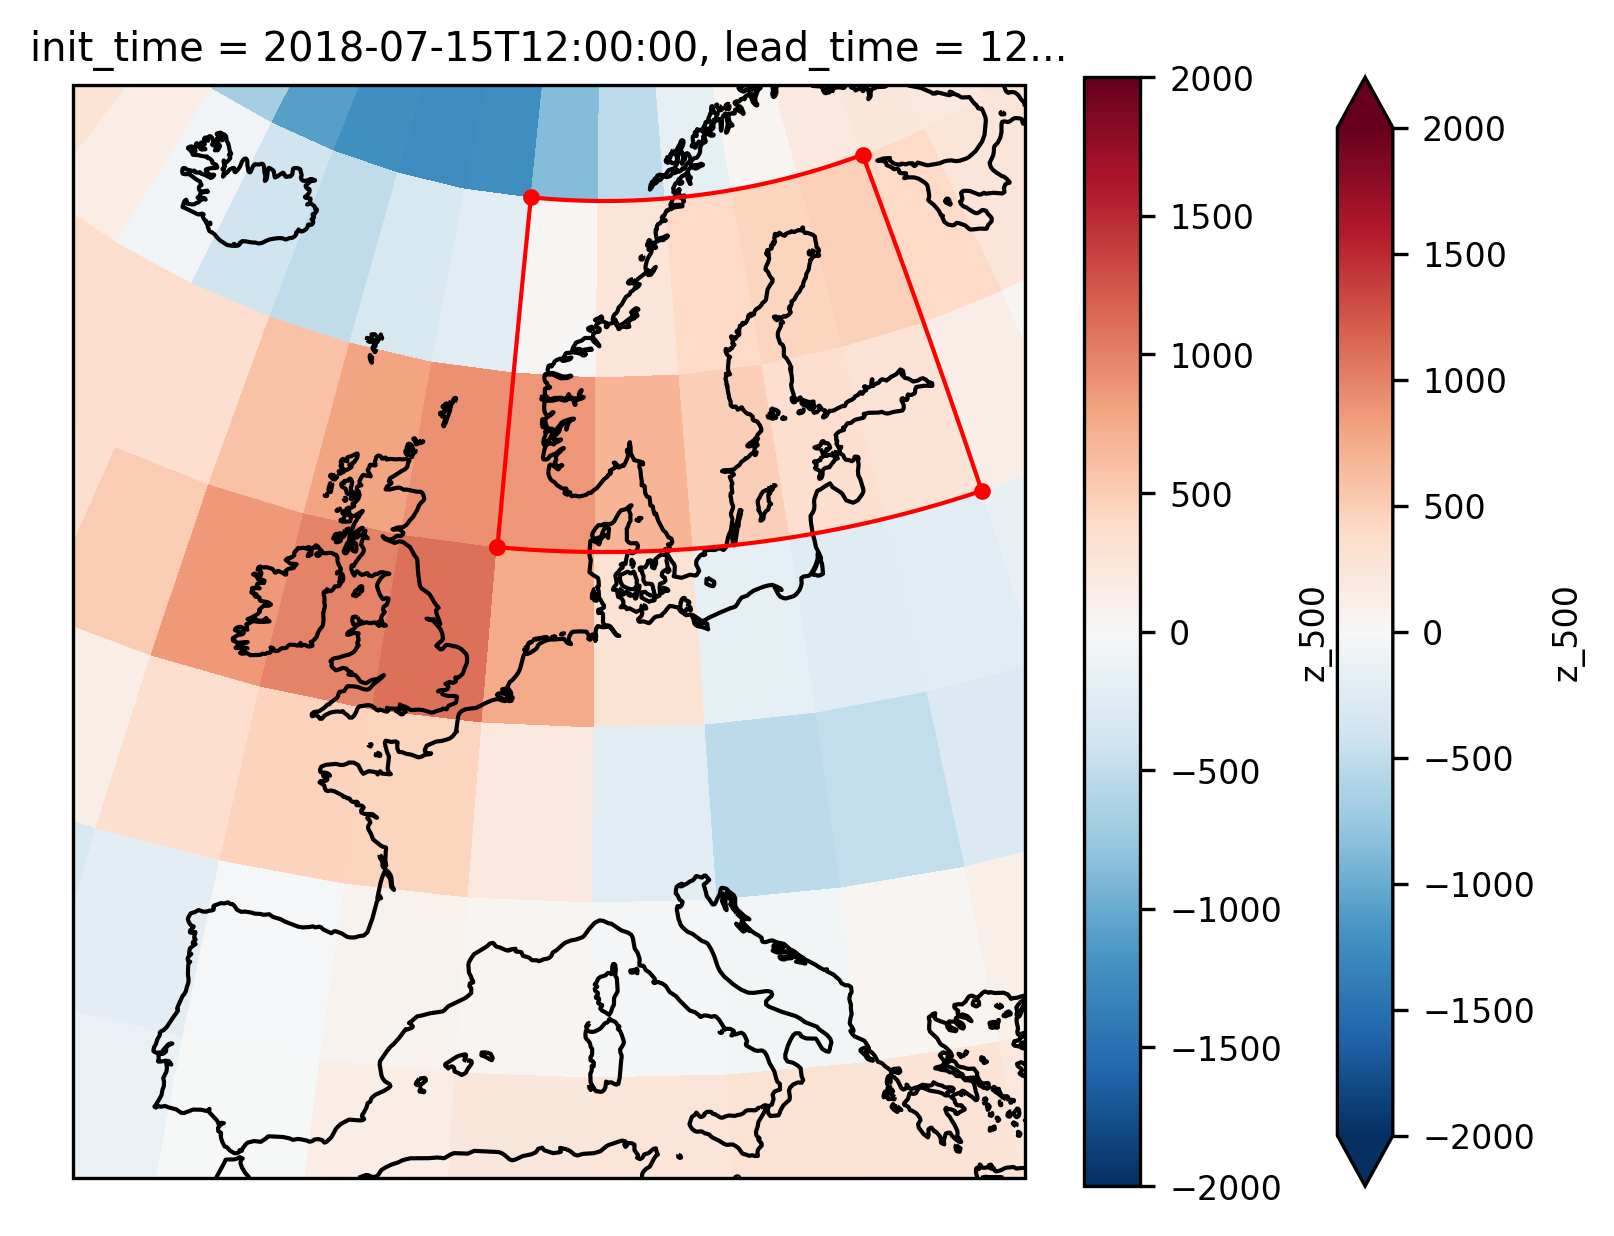

In [82]:
fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.EuroPP()))

timestep = 10

predictions_anomaly.z_500.isel({"init_time":timestep, "lead_time":0, "ensemble_member":0}).plot(ax=axis, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=-2000, vmax=2000)
predictions_inner.z_500.isel({"init_time":timestep}).plot(ax=axis, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=-2000, vmax=2000)

axis.coastlines()

axis.plot([lon_min, lon_min, lon_max, lon_max, lon_min], [lat_min, lat_max, lat_max, lat_min, lat_min],
         color='red', linewidth=1, marker='o', markersize=3,
         # Be explicit about which transform you want:
         transform=ccrs.PlateCarree())

plt.show()

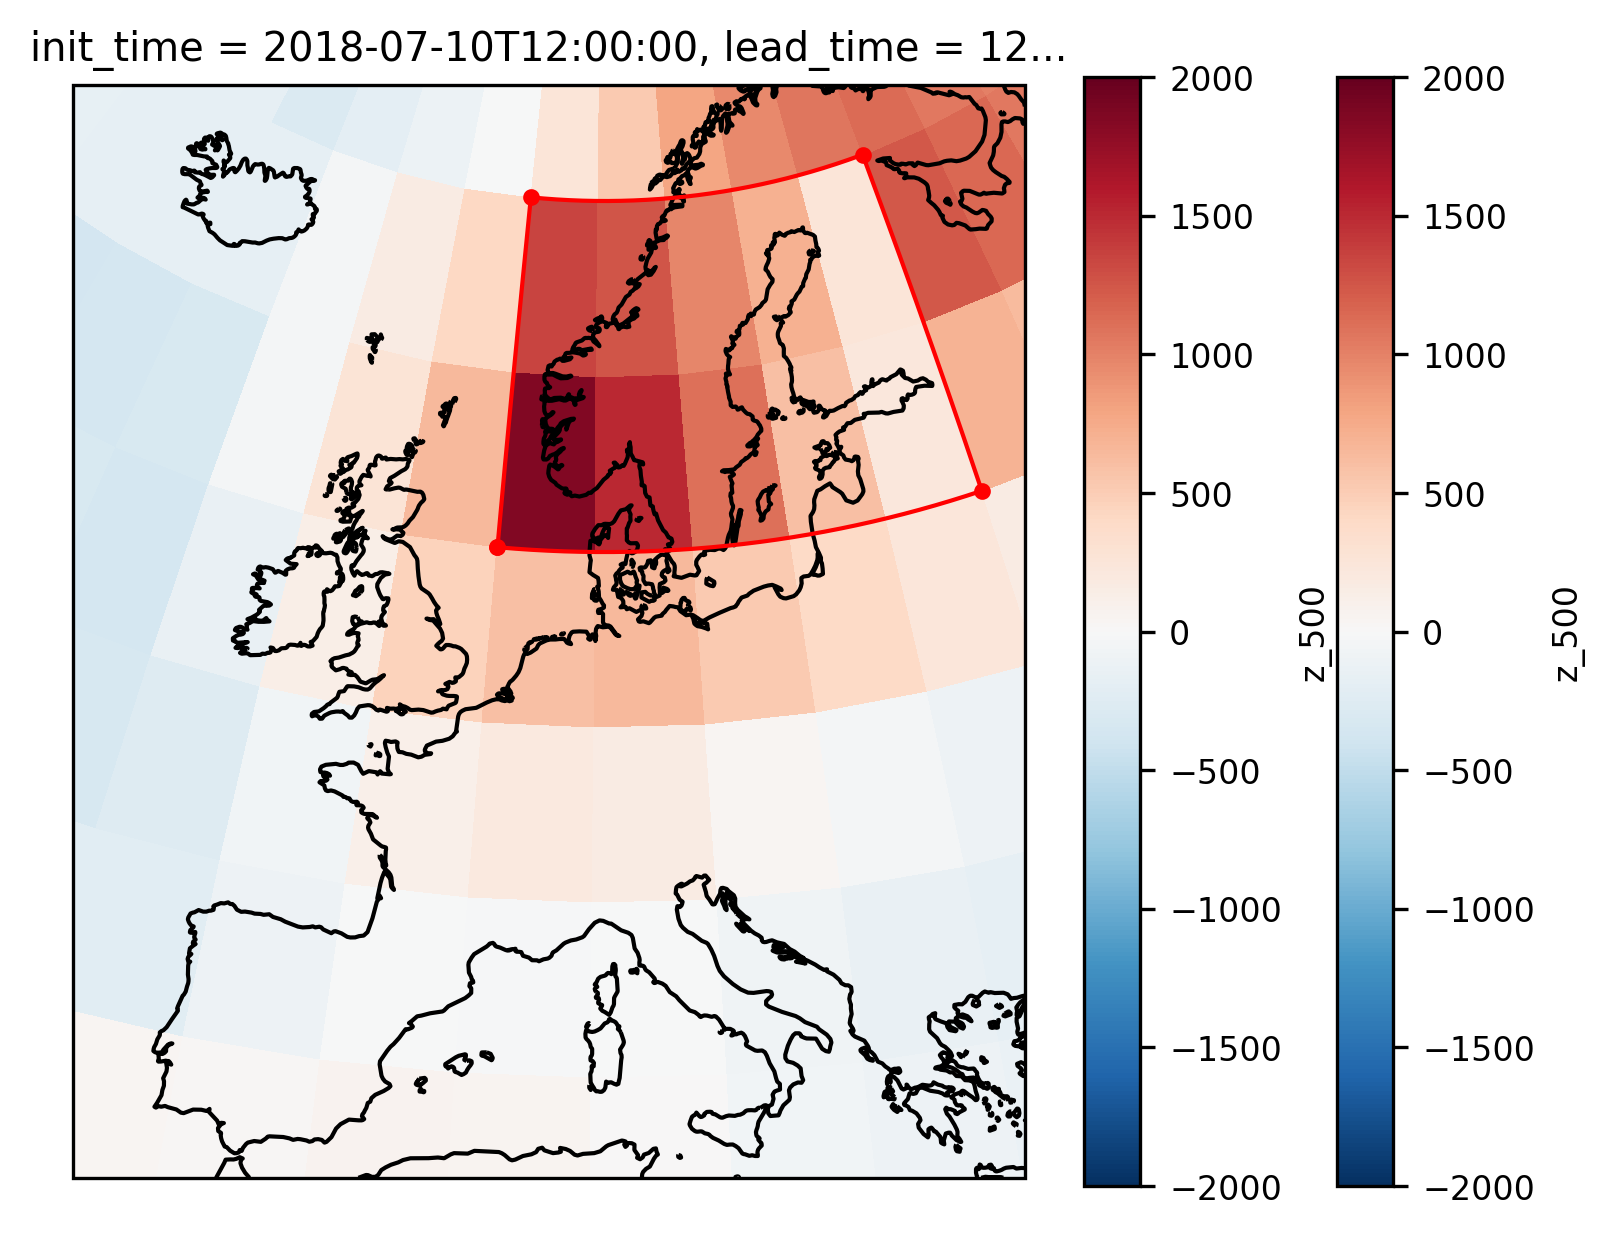

In [71]:
fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.EuroPP()))

timestep = 5

predictions_anomaly.z_500.isel({"init_time": slice(10,-10), "lead_time":0, "ensemble_member":0}).mean("init_time").plot(ax=axis, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=-2000, vmax=2000)
predictions_inner.z_500.isel({"init_time":timestep}).plot(ax=axis, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=-2000, vmax=2000)

axis.coastlines()

axis.plot([lon_min, lon_min, lon_max, lon_max, lon_min], [lat_min, lat_max, lat_max, lat_min, lat_min],
         color='red', linewidth=1, marker='o', markersize=3,
         # Be explicit about which transform you want:
         transform=ccrs.PlateCarree())

plt.show()

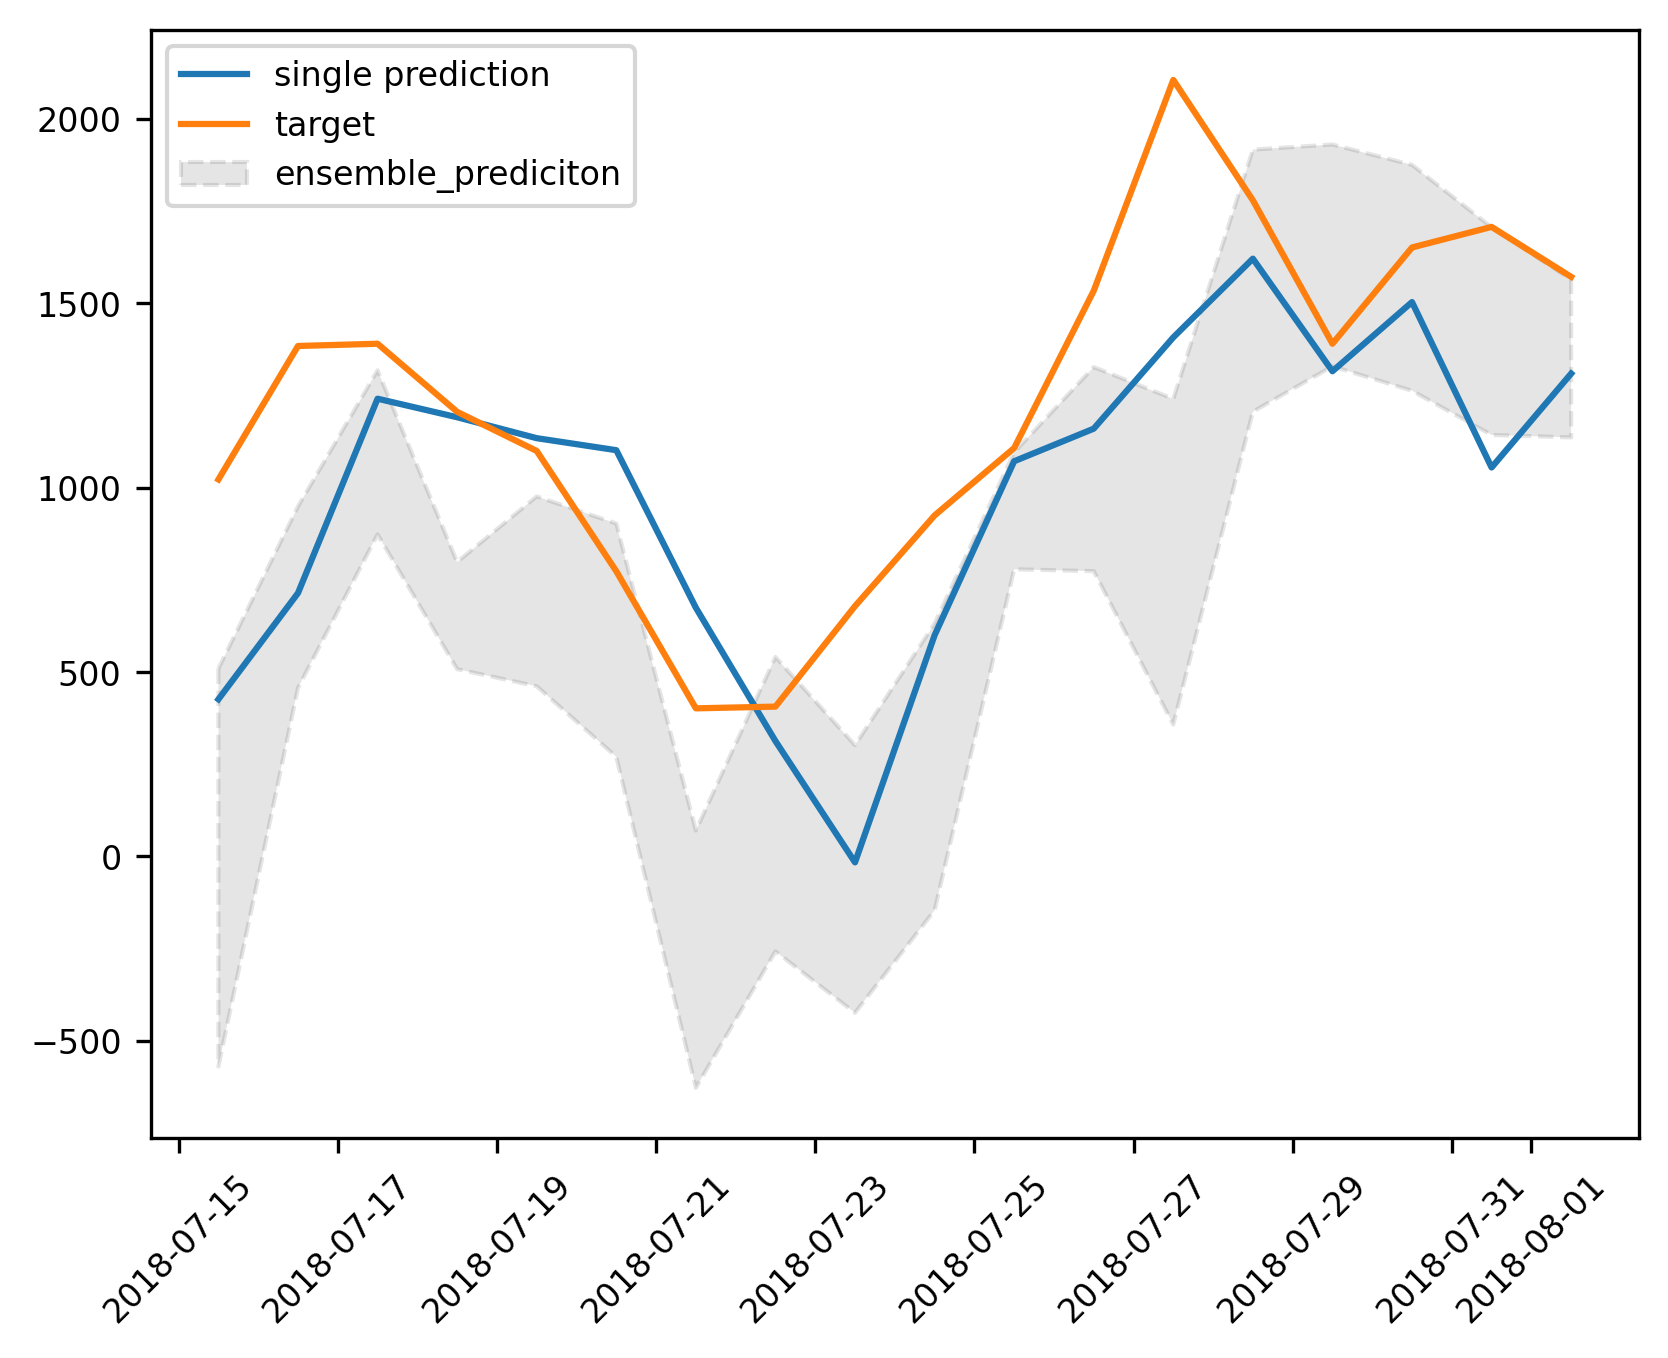

In [81]:
p = predictions_inner.mean({"lat", "lon"}).z_500.isel(init_time=slice(10,-10))
t = targets_inner.mean({"lat", "lon"}).z_500.isel(init_time=slice(10,-10))
p_e = predictions_ensemble_inner.mean({"lat", "lon"}).z_500.isel(init_time=slice(10,-10))

plt.plot(p.init_time, p, label="single prediction")
plt.plot(p.init_time, t, label="target")

plt.fill_between(p.init_time, np.min(p_e, axis=0), np.max(p_e, axis=0), alpha=0.1, color="k", linestyle="--", label="ensemble_prediciton")
plt.xticks(rotation=45)
plt.legend()
plt.show()

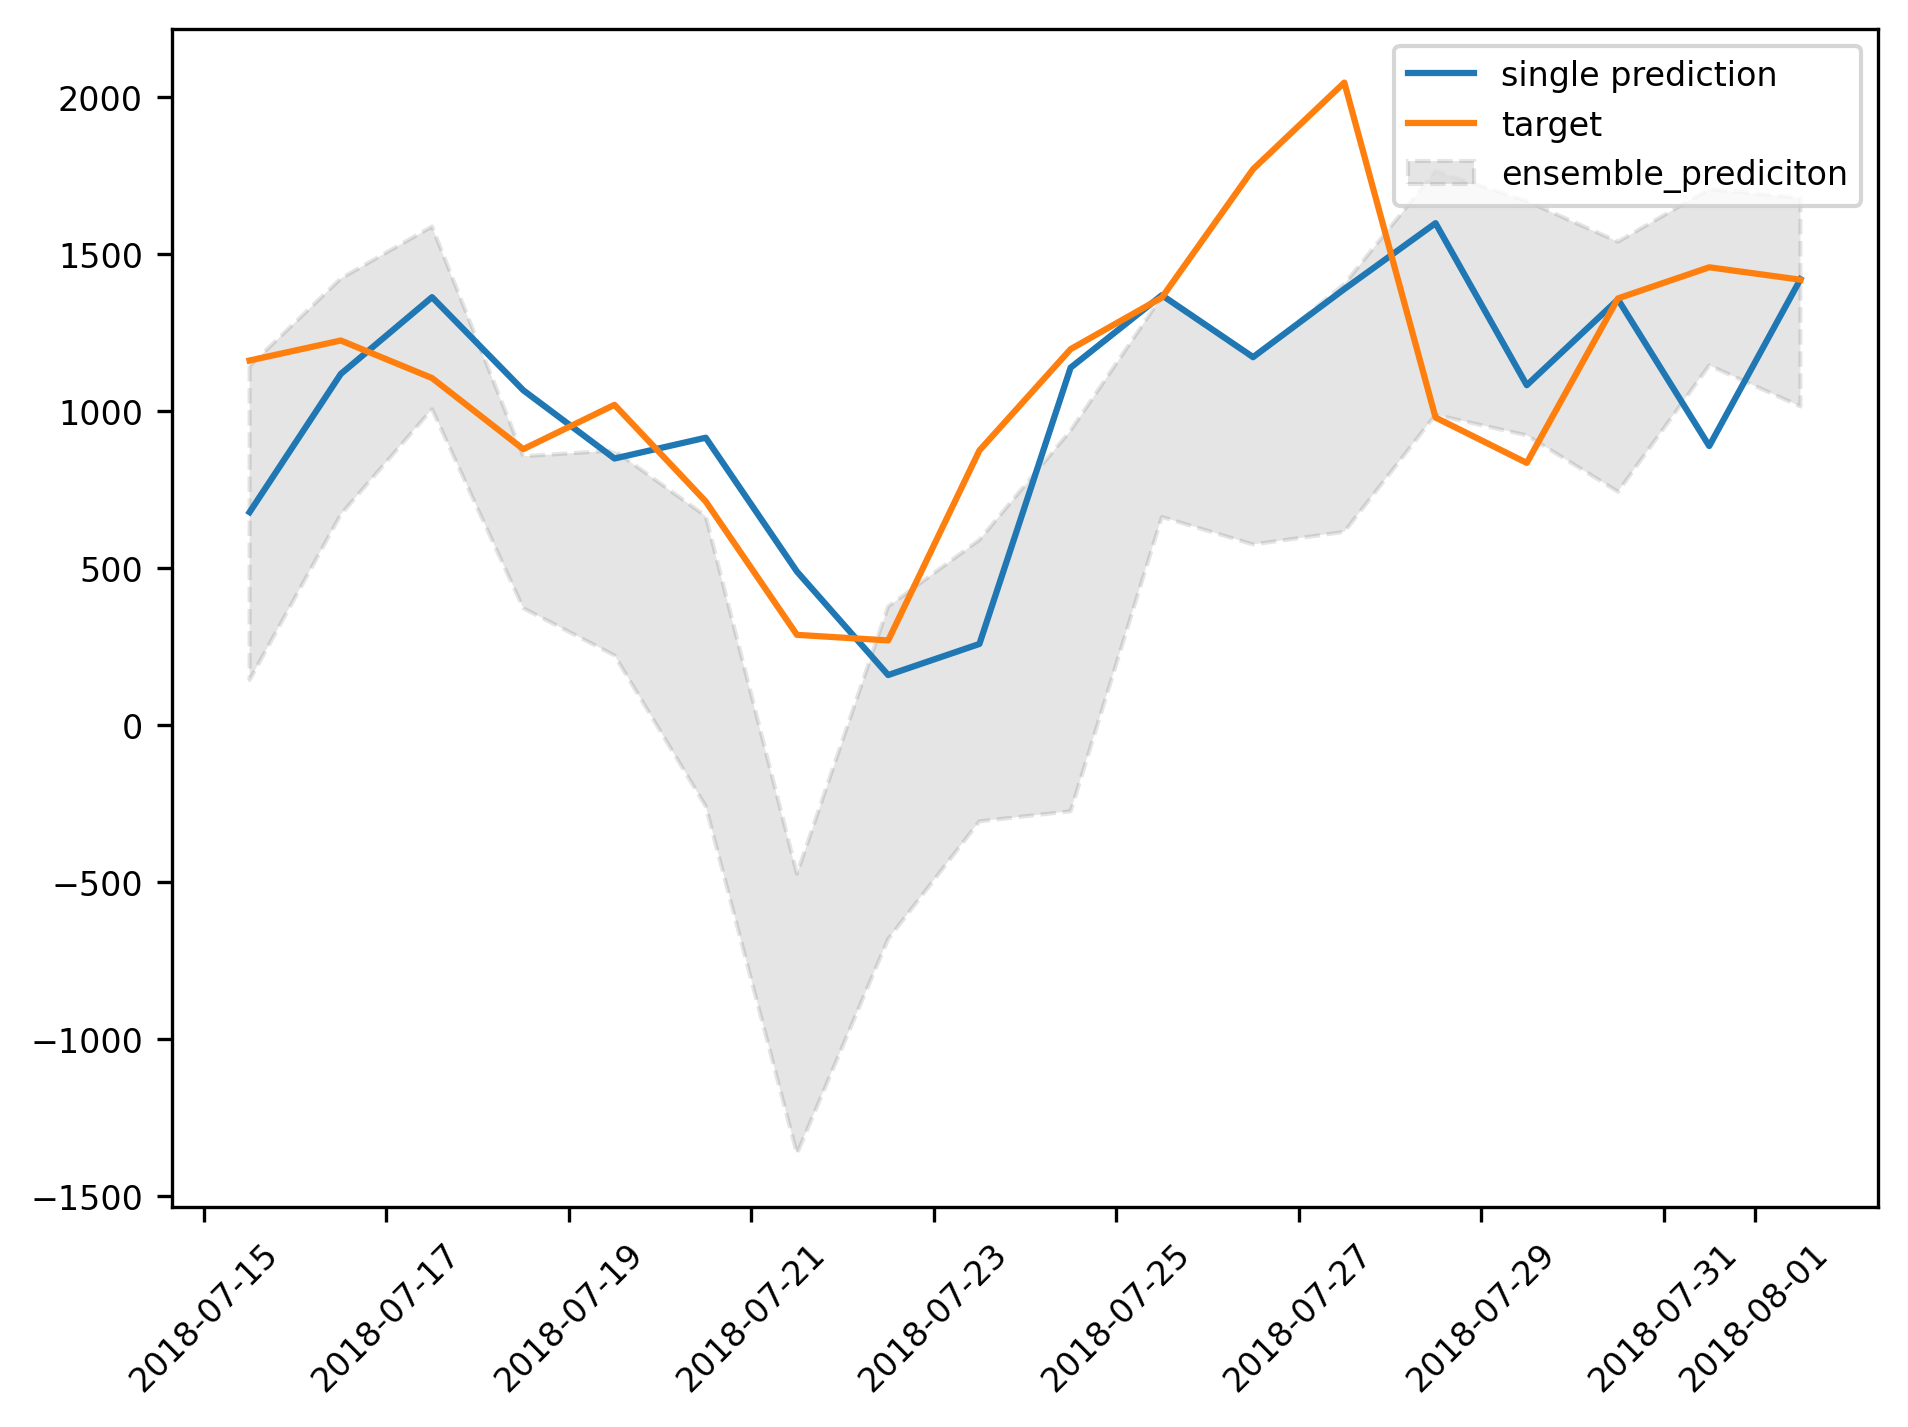

In [80]:
p = predictions_inner.isel({"lat": 0, "lon": 1}).z_500.isel(init_time=slice(10,-10))
t = targets_inner.isel({"lat": 0, "lon": 1}).z_500.isel(init_time=slice(10,-10))
p_e = predictions_ensemble_inner.isel({"lat": 0, "lon": 1}).z_500.isel(init_time=slice(10,-10))

plt.plot(p.init_time, p, label="single prediction")
plt.plot(p.init_time, t, label="target")

plt.fill_between(p.init_time, np.min(p_e, axis=0), np.max(p_e, axis=0), alpha=0.1, color="k", linestyle="--", label="ensemble_prediciton")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [76]:
predictions_inner.init_time

<xarray.DataArray 'init_time' (init_time: 38)>
array(['2018-07-05T12:00:00.000000000', '2018-07-06T12:00:00.000000000',
       '2018-07-07T12:00:00.000000000', '2018-07-08T12:00:00.000000000',
       '2018-07-09T12:00:00.000000000', '2018-07-10T12:00:00.000000000',
       '2018-07-11T12:00:00.000000000', '2018-07-12T12:00:00.000000000',
       '2018-07-13T12:00:00.000000000', '2018-07-14T12:00:00.000000000',
       '2018-07-15T12:00:00.000000000', '2018-07-16T12:00:00.000000000',
       '2018-07-17T12:00:00.000000000', '2018-07-18T12:00:00.000000000',
       '2018-07-19T12:00:00.000000000', '2018-07-20T12:00:00.000000000',
       '2018-07-21T12:00:00.000000000', '2018-07-22T12:00:00.000000000',
       '2018-07-23T12:00:00.000000000', '2018-07-24T12:00:00.000000000',
       '2018-07-25T12:00:00.000000000', '2018-07-26T12:00:00.000000000',
       '2018-07-27T12:00:00.000000000', '2018-07-28T12:00:00.000000000',
       '2018-07-29T12:00:00.000000000', '2018-07-30T12:00:00.000000000',
       '2018-07-31T12:00:00.000000000', '2018-08-01T12:00:00.000000000',
       '2018-08-02T12:00:00.000000000', '2018-08-03T12:00:00.000000000',
       '2018-08-04T12:00:00.000000000', '2018-08-05T12:00:00.000000000',
       '2018-08-06T12:00:00.000000000', '2018-08-07T12:00:00.000000000',
       '2018-08-08T12:00:00.000000000', '2018-08-09T12:00:00.000000000',
       '2018-08-10T12:00:00.000000000', '2018-08-11T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * init_time        (init_time) datetime64[ns] 2018-07-05T12:00:00 ... 2018-...
    lead_time        int64 12
    ensemble_member  int64 0
    level            int32 500
    dayofyear        (init_time) int64 186 187 188 189 190 ... 220 221 222 223